In [1]:
from typing import Literal

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

from SimAgent.tools import simulate_structure, python_repl, tavily_tool

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='6'

In [3]:
tools = [simulate_structure, tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [4]:
model_with_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

In [5]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

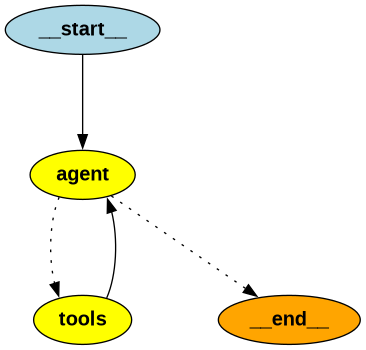

In [6]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_png()))


In [9]:
# example with a single tool call
for chunk in app.stream(
    {
        "messages": [
            (
                "human",
                "Can you simulate insulin.pdb in the local dir? ",
            )
        ]
    },
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Can you simulate insulin.pdb in the local dir? 
================================== Ai Message ==================================
Tool Calls:
  simulate_structure (call_Ygijnlq1OAJHgzT79mI2X6Uo)
 Call ID: call_Ygijnlq1OAJHgzT79mI2X6Uo
  Args:
    pdb_file: insulin.pdb
================================= Tool Message =================================
Name: simulate_structure

null
================================== Ai Message ==================================

The simulation for the insulin structure in the provided PDB file has been initiated successfully. If you have any specific questions or need further assistance, feel free to ask!
